## Raw Layer Analysis
### Data Vizualization

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
from IPython.display import display, Markdown

In [2]:
# Definir o diretório base onde estão os arquivos CSV
data_dir = "./"

# Carregar dados de referência
posicoes = pd.read_csv(os.path.join(data_dir, "posicoes.csv"))
pontuacao = pd.read_csv(os.path.join(data_dir, "pontuacao.csv"))
status = pd.read_csv(os.path.join(data_dir, "status.csv"))

print("Arquivos de referência carregados:")
print(f"- Posições: {len(posicoes)} registros")
print(f"- Pontuação: {len(pontuacao)} registros")
print(f"- Status: {len(status)} registros")

Arquivos de referência carregados:
- Posições: 6 registros
- Pontuação: 18 registros
- Status: 5 registros


### Read Data

In [3]:
# Função para carregar e processar dados de um ano
def load_year_data(year, data_dir="./"):
    # Carregar dados do ano
    atletas = pd.read_csv(os.path.join(data_dir, f"{year}_atletas.csv"))
    clubes = pd.read_csv(os.path.join(data_dir, f"{year}_clubes.csv"))
    partidas = pd.read_csv(os.path.join(data_dir, f"{year}_partidas.csv"))
    scouts = pd.read_csv(os.path.join(data_dir, f"{year}_scouts.csv"))
    
    # Fazer joins para criar dataset consolidado
    # Atletas + Clubes + Posições
    df_base = atletas.merge(clubes, left_on='clube_id', right_on='id', suffixes=('', '_clube'))
    df_base = df_base.merge(posicoes, left_on='posicao_id', right_on='id', suffixes=('', '_posicao'))
    
    # Scouts + dados base
    df_year = scouts.merge(df_base, left_on='atleta_id', right_on='id', suffixes=('', '_atleta'))
    
    # Adicionar informações de partidas quando disponível
    if 'partida_id' in df_year.columns:
        df_year = df_year.merge(partidas, left_on='partida_id', right_on='id', suffixes=('', '_partida'))
        df_year = df_year.rename(columns={
            'rodada_partida': 'partida_rodada',
            'placar_oficial_mandante': 'partida_placar_mandante',
            'placar_oficial_visitante': 'partida_placar_visitante'
        })
    else:
        # Usar rodada do scouts se partida_id não estiver disponível
        df_year['partida_rodada'] = df_year['rodada']
    
    # Renomear colunas para manter compatibilidade
    df_year = df_year.rename(columns={
        'apelido': 'atleta_apelido',
        'nome': 'clube_nome',
        'abreviacao': 'clube_abreviacao', 
        'nome_posicao': 'atleta_posicao',
        'pontos_num': 'scout_pontos_num',
        'preco_num': 'scout_preco_num',
        'jogos_num': 'scout_jogos_num',
        'variacao_num': 'scout_variacao_num'
    })
    
    # Adicionar coluna de temporada
    df_year['temporada'] = year
    
    return df_year

# Carregar dados de todas as temporadas
anos = [2014, 2015, 2016, 2017]
dfs_anos = []

for ano in anos:
    try:
        df_ano = load_year_data(ano)
        dfs_anos.append(df_ano)
        print(f"Dados de {ano} carregados: {len(df_ano)} registros")
    except Exception as e:
        print(f"Erro ao carregar dados de {ano}: {e}")

# Combinar todos os anos
df = pd.concat(dfs_anos, ignore_index=True)
print(f"\nDataset consolidado: {len(df)} registros")

df.head()

Dados de 2014 carregados: 17471 registros
Dados de 2015 carregados: 26184 registros


Dados de 2016 carregados: 31168 registros
Erro ao carregar dados de 2017: 'clube_id'

Dataset consolidado: 74823 registros


,atleta_id,rodada,clube_id,participou,posicao_id,scout_jogos_num,scout_pontos_num,media_num,scout_preco_num,scout_variacao_num,...,id_posicao,atleta_posicao,abreviacao_posicao,id_partida,partida_rodada,clube_casa_id,clube_visitante_id,partida_placar_mandante,partida_placar_visitante,temporada
0,37958,1,262.0,1,1.0,1.0,8.0,8.0,19.69,1.69,...,1,Goleiro,gol,179872.0,1,262.0,290.0,0.0,0.0,2014
1,68873,1,262.0,0,1.0,0.0,0.0,0.0,4.00,0.00,...,1,Goleiro,gol,179872.0,1,262.0,290.0,0.0,0.0,2014
2,37701,1,262.0,1,2.0,1.0,0.4,0.4,16.97,-5.03,...,2,Lateral,lat,179872.0,1,262.0,290.0,0.0,0.0,2014
3,71602,1,262.0,0,2.0,0.0,0.0,0.0,3.00,0.00,...,2,Lateral,lat,179872.0,1,262.0,290.0,0.0,0.0,2014
4,37684,1,262.0,1,3.0,1.0,9.1,9.1,10.68,5.68,...,3,Zagueiro,zag,179872.0,1,262.0,290.0,0.0,0.0,2014


In [4]:
# Conferir colunas e tipos
print("Colunas e tipos de dados:")
df.info()

# Dataframe filtrado apenas para jogadores que jogaram (excluindo os que ficaram no banco de reservas/não relacionados)
df_atuou = df[(df["scout_pontos_num"] != 0)]

Colunas e tipos de dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74823 entries, 0 to 74822
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   atleta_id                 74823 non-null  int64  
 1   rodada                    74823 non-null  int64  
 2   clube_id                  73683 non-null  float64
 3   participou                48639 non-null  object 
 4   posicao_id                73690 non-null  float64
 5   scout_jogos_num           43655 non-null  float64
 6   scout_pontos_num          74823 non-null  float64
 7   media_num                 74823 non-null  float64
 8   scout_preco_num           74823 non-null  float64
 9   scout_variacao_num        74823 non-null  float64
 10  partida_id                17471 non-null  float64
 11  mando                     17471 non-null  float64
 12  titular                   16338 non-null  float64
 13  substituido               17471 non

In [5]:
print("Valores únicos por temporada:")
print(df["temporada"].value_counts())

Valores únicos por temporada:
temporada
2016    31168
2015    26184
2014    17471
Name: count, dtype: int64


In [6]:
print("Valores únicos por clube:")
print(df["clube_nome"].value_counts())

Valores únicos por clube:
clube_nome
Corinthians      4679
Figueirense      4107
Internacional    4037
Sport            3995
Santos           3933
Atlético-PR      3922
Grêmio           3918
Cruzeiro         3869
Chapecoense      3811
Palmeiras        3809
Atlético-MG      3712
Fluminense       3487
Flamengo         3438
São Paulo        3437
Ponte Preta      2531
Coritiba         2449
Vitória          2378
Botafogo         2366
Goiás            2174
Santa Cruz       1571
América-MG       1423
Avaí             1399
Joinville        1351
Vasco            1254
Criciúma          909
Bahia             864
Name: count, dtype: int64


O DataFrame `df` contém **102.309 registros** com **39 colunas**, representando dados de jogadores de futebol coletados para análise de desempenho nas temporadas de 2014 à 2017.

As colunas incluem informações de identificação do jogador (`atleta_id`, `atleta_apelido`), do clube (`clube_nome`, `clube_abreviacao`), detalhes da partida (`partida_rodada`, `partida_placar_mandante`, `partida_placar_visitante`), posição do jogador (`atleta_posicao`) e diversas métricas de scout (`scout_pontos_num`, `scout_ponto_por_gol`, `scout_ponto_por_assistencia`, entre outras). Com essas métricas, o jogo Cartola calcula a pontuação do jogador na rodada, gerando a coluna `scout_pontos_num` e o jogador é precificado, gerando a coluna `scout_preco_num`. Usaremos essas informações para fazer os comparativos e gerar os gráficos.



### Regressão Linear: Preço do Jogador x Média de Pontos

Neste gráfico, vamos analisar a relação entre o preço dos jogadores (`scout_preco_num`) e a média de pontos que eles fizeram (`scout_pontos_num`) com o objetivo de compreender se os jogadores mais caros pontuam mais.

Abaixo são as tabelas de cada temporada disponível e no final com todas as temporadas: 

In [7]:
def jogador_info(df, coluna, tipo="min"):
    if tipo == "min":
        linha = df[df[coluna] == df[coluna].min()].iloc[0]
    else:
        linha = df[df[coluna] == df[coluna].max()].iloc[0]
    return linha["atleta_apelido"], linha["atleta_posicao"], linha["clube_nome"]

### Informações de preço e pontuação da temporada de 2014

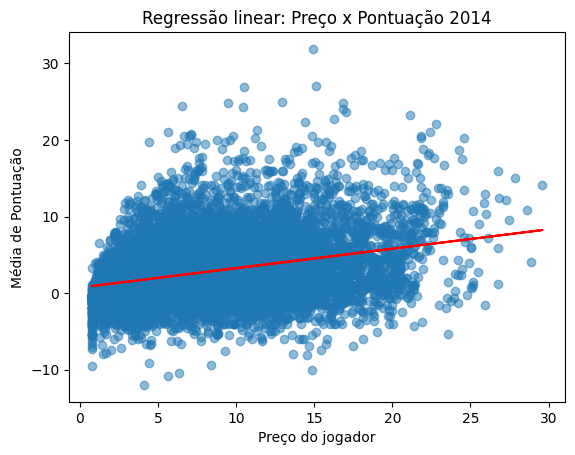

### Estatísticas do Preço do Jogador

,Valor,Atleta,Posição,Clube
Mínimo,0.76000,Mattheus,Meia,Flamengo
Média,8.24251,-,-,-
Máximo,29.61000,Fred,Atacante,Fluminense


### Estatísticas de Pontuação

,Pontos,Atleta,Posição,Clube
Mínimo,-12.00000,Galatto,Goleiro,Criciúma
Média,2.80702,-,-,-
Máximo,31.90000,Daniel,Meia,Botafogo


In [8]:
df_2014 = df_atuou[df_atuou["temporada"] == 2014]

x = df_2014["scout_preco_num"]
y = df_2014["scout_pontos_num"]

# Regressão linear
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

plt.scatter(x, y, alpha=0.5)
plt.plot(x, poly1d_fn(x), color="red")
plt.xlabel("Preço do jogador")
plt.ylabel("Média de Pontuação")
plt.title("Regressão linear: Preço x Pontuação 2014")
plt.show()

x = df_2014["scout_preco_num"]
y = df_2014["scout_pontos_num"]

preco_min = jogador_info(df_2014, "scout_preco_num", "min")
preco_max = jogador_info(df_2014, "scout_preco_num", "max")

# Tabela de informações de preço dos jogadores (em cartoletas)
tabela_preco = pd.DataFrame({
    "Valor": [x.min(), x.mean(), x.max()],
    "Atleta": [preco_min[0], "-", preco_max[0]],
    "Posição": [preco_min[1], "-", preco_max[1]],
    "Clube": [preco_min[2], "-", preco_max[2]]
}, index=["Mínimo", "Média", "Máximo"])


media_min = jogador_info(df_2014, "scout_pontos_num", "min")
media_max = jogador_info(df_2014, "scout_pontos_num", "max")

# Tabela de informações de pontuação dos jogadores
tabela_media = pd.DataFrame({
    "Pontos": [y.min(), y.mean(), y.max()],
    "Atleta": [media_min[0], "-", media_max[0]],
    "Posição": [media_min[1], "-", media_max[1]],
    "Clube": [media_min[2], "-", media_max[2]]
}, index=["Mínimo", "Média", "Máximo"])

# Exibir tabelas

display(Markdown("### Estatísticas do Preço do Jogador"))
display(tabela_preco)

display(Markdown("### Estatísticas de Pontuação"))
display(tabela_media)

### Informações de preço e pontuação da temporada de 2015

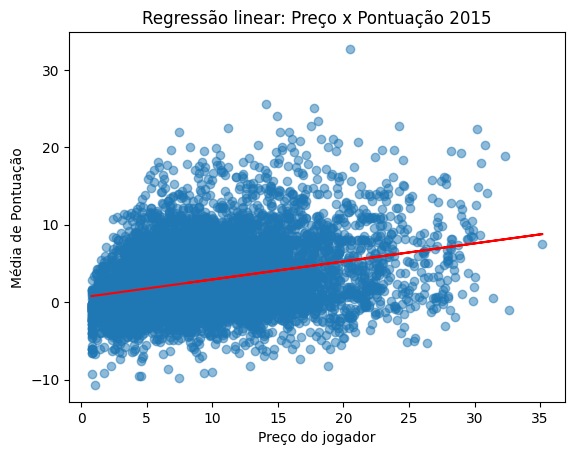

### Estatísticas do Preço do Jogador

,Valor,Atleta,Posição,Clube
Mínimo,C$ 0.79,Lucas Mugni,Meia,Flamengo
Média,C$ 9.42,-,-,-
Máximo,C$ 35.18,Diego Souza,Meia,Sport


### Estatísticas de Pontuação

,Pontos,Atleta,Posição,Clube
Mínimo,-10.700000,Victor Ramos,Zagueiro,Palmeiras
Média,2.785464,-,-,-
Máximo,32.700000,Willian,Atacante,Cruzeiro


In [9]:
df_2015 = df_atuou[df_atuou["temporada"] == 2015]

x = df_2015["scout_preco_num"]
y = df_2015["scout_pontos_num"]

# Regressão linear
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

plt.scatter(x, y, alpha=0.5)
plt.plot(x, poly1d_fn(x), color="red")
plt.xlabel("Preço do jogador")
plt.ylabel("Média de Pontuação")
plt.title("Regressão linear: Preço x Pontuação 2015")
plt.show()

preco_min = jogador_info(df_2015, "scout_preco_num", "min")
preco_max = jogador_info(df_2015, "scout_preco_num", "max")

# Tabela de informações de preço dos jogadores (em cartoletas)
tabela_preco = pd.DataFrame({
    "Valor": [x.min(), x.mean(), x.max()],
    "Atleta": [preco_min[0], "-", preco_max[0]],
    "Posição": [preco_min[1], "-", preco_max[1]],
    "Clube": [preco_min[2], "-", preco_max[2]]
}, index=["Mínimo", "Média", "Máximo"])


min = jogador_info(df_2015, "scout_pontos_num", "min")
max = jogador_info(df_2015, "scout_pontos_num", "max")

# Tabela de informações de pontuação dos jogadores
tabela_media = pd.DataFrame({
    "Pontos": [y.min(), y.mean(), y.max()],
    "Atleta": [min[0], "-", max[0]],
    "Posição": [min[1], "-", max[1]],
    "Clube": [min[2], "-", max[2]]
}, index=["Mínimo", "Média", "Máximo"])

# Exibir tabelas

display(Markdown("### Estatísticas do Preço do Jogador"))
display(tabela_preco.style.format({"Valor": "C$ {:,.2f}"}))

display(Markdown("### Estatísticas de Pontuação"))
display(tabela_media)


### Informações de preço e pontuação da temporada de 2016

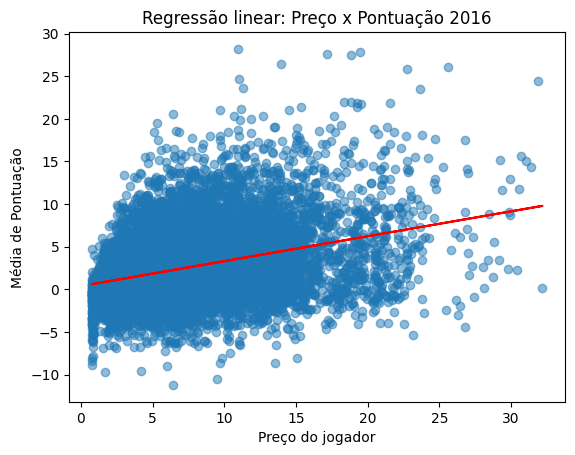

### Estatísticas do Preço do Jogador

,Valor,Atleta,Posição,Clube
Mínimo,C$ 0.74,Emerson,Atacante,Flamengo
Média,C$ 7.95,-,-,-
Máximo,C$ 32.20,Gabriel Jesus,Atacante,Palmeiras


### Estatísticas de Pontuação

,Pontos,Atleta,Posição,Clube
Mínimo,-11.200000,Victor Ramos,Zagueiro,Vitória
Média,2.714314,-,-,-
Máximo,28.200000,Sassá,Atacante,Botafogo


In [10]:
df_2016 = df_atuou[df_atuou["temporada"] == 2016]

x = df_2016["scout_preco_num"]
y = df_2016["scout_pontos_num"]

# Regressão linear
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

plt.scatter(x, y, alpha=0.5)
plt.plot(x, poly1d_fn(x), color="red")
plt.xlabel("Preço do jogador")
plt.ylabel("Média de Pontuação")
plt.title("Regressão linear: Preço x Pontuação 2016")
plt.show()

preco_min = jogador_info(df_2016, "scout_preco_num", "min")
preco_max = jogador_info(df_2016, "scout_preco_num", "max")

# Tabela de informações de preço dos jogadores (em cartoletas)
tabela_preco = pd.DataFrame({
    "Valor": [x.min(), x.mean(), x.max()],
    "Atleta": [preco_min[0], "-", preco_max[0]],
    "Posição": [preco_min[1], "-", preco_max[1]],
    "Clube": [preco_min[2], "-", preco_max[2]]
}, index=["Mínimo", "Média", "Máximo"])


min = jogador_info(df_2016, "scout_pontos_num", "min")
max = jogador_info(df_2016, "scout_pontos_num", "max")

# Tabela de informações de pontuação dos jogadores
tabela_media = pd.DataFrame({
    "Pontos": [y.min(), y.mean(), y.max()],
    "Atleta": [min[0], "-", max[0]],
    "Posição": [min[1], "-", max[1]],
    "Clube": [min[2], "-", max[2]]
}, index=["Mínimo", "Média", "Máximo"])

# Exibir tabelas
display(Markdown("### Estatísticas do Preço do Jogador"))
display(tabela_preco.style.format({"Valor": "C$ {:,.2f}"}))

display(Markdown("### Estatísticas de Pontuação"))
display(tabela_media)


### Informações de preço e pontuação da temporada de 2016

In [11]:
df_2017 = df_atuou[df_atuou["temporada"] == 2017]

if df_2017.empty:
    print("Não há dados disponíveis para a temporada de 2017.")
else:
    x = df_2017["scout_preco_num"]
    y = df_2017["scout_pontos_num"]

    coef = np.polyfit(x, y, 1)
    poly1d_fn = np.poly1d(coef)

    plt.scatter(x, y, alpha=0.5)
    plt.plot(x, poly1d_fn(x), color="red")
    plt.xlabel("Preço do jogador")
    plt.ylabel("Média de Pontuação")
    plt.title("Regressão linear: Preço x Pontuação 2017")
    plt.show()

    preco_min = jogador_info(df_2017, "scout_preco_num", "min")
    preco_max = jogador_info(df_2017, "scout_preco_num", "max")

    tabela_preco = pd.DataFrame({
        "Valor": [x.min(), x.mean(), x.max()],
        "Atleta": [preco_min[0], "-", preco_max[0]],
        "Posição": [preco_min[1], "-", preco_max[1]],
        "Clube": [preco_min[2], "-", preco_max[2]]
    }, index=["Mínimo", "Média", "Máximo"])


    pontos_min = jogador_info(df_2017, "scout_pontos_num", "min")
    pontos_max = jogador_info(df_2017, "scout_pontos_num", "max")

    tabela_media = pd.DataFrame({
        "Pontos": [y.min(), y.mean(), y.max()],
        "Atleta": [pontos_min[0], "-", pontos_max[0]],
        "Posição": [pontos_min[1], "-", pontos_max[1]],
        "Clube": [pontos_min[2], "-", pontos_max[2]]
    }, index=["Mínimo", "Média", "Máximo"])


    display(Markdown("### Estatísticas do Preço do Jogador"))
    display(tabela_preco.style.format({"Valor": "C$ {:,.2f}"}))

    display(Markdown("### Estatísticas de Pontuação"))
    display(tabela_media)


Não há dados disponíveis para a temporada de 2017.


### Informações de preço e pontuação das temporadas de 2014 à 2017

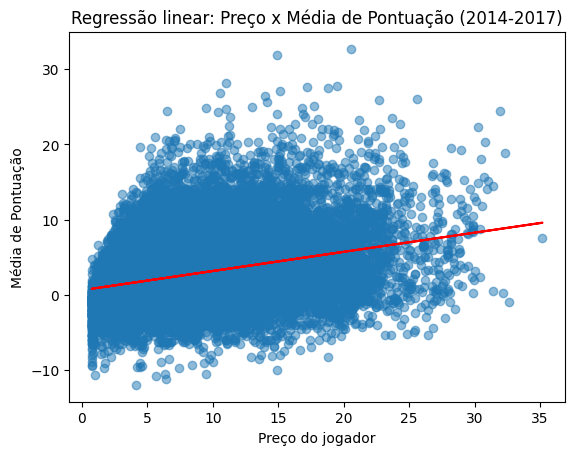

### Estatísticas do Preço do Jogador

,Valor,Atleta,Posição,Clube
Mínimo,C$ 0.74,Emerson,Atacante,Flamengo
Média,C$ 8.49,-,-,-
Máximo,C$ 35.18,Diego Souza,Meia,Sport


### Estatísticas de Pontuação

,Pontos,Atleta,Posição,Clube
Mínimo,-12.000000,Galatto,Goleiro,Criciúma
Média,2.767905,-,-,-
Máximo,32.700000,Willian,Atacante,Cruzeiro


In [12]:
x = df_atuou["scout_preco_num"]
y = df_atuou["scout_pontos_num"]

# Regressão linear
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

plt.scatter(x, y, alpha=0.5)
plt.plot(x, poly1d_fn(x), color="red")
plt.xlabel("Preço do jogador")
plt.ylabel("Média de Pontuação")
plt.title("Regressão linear: Preço x Média de Pontuação (2014-2017)")
plt.show()

preco_min = jogador_info(df_atuou, "scout_preco_num", "min")
preco_max = jogador_info(df_atuou, "scout_preco_num", "max")

tabela_preco = pd.DataFrame({
    "Valor": [x.min(), x.mean(), x.max()],
    "Atleta": [preco_min[0], "-", preco_max[0]],
    "Posição": [preco_min[1], "-", preco_max[1]],
    "Clube": [preco_min[2], "-", preco_max[2]]
}, index=["Mínimo", "Média", "Máximo"])


media_min = jogador_info(df_atuou, "scout_pontos_num", "min")
media_max = jogador_info(df_atuou, "scout_pontos_num", "max")

tabela_media = pd.DataFrame({
    "Pontos": [y.min(), y.mean(), y.max()],
    "Atleta": [media_min[0], "-", media_max[0]],
    "Posição": [media_min[1], "-", media_max[1]],
    "Clube": [media_min[2], "-", media_max[2]]
}, index=["Mínimo", "Média", "Máximo"])


display(Markdown("### Estatísticas do Preço do Jogador"))
display(tabela_preco.style.format({"Valor": "C$ {:,.2f}"}))

display(Markdown("### Estatísticas de Pontuação"))
display(tabela_media)


### Boxplot: Pontuação do jogador pela posição
Nesta etapa, vamos investigar como a média de pontuação dos jogadores varia de acordo com suas posições em campo.  
O **gráfico de boxplot** abaixo mostra a **distribuição de pontos** por posição, destacando a mediana, a variação e possíveis outliers(jogadores que pontuaram muito acima ou abaixo da média).  

In [13]:
def jogador_info_posicao(df, coluna, tipo="min"):
    # Filtrar apenas as posições desejadas
    posicoes = df["atleta_posicao"].unique()
    df_filtrado = df[df["atleta_posicao"].isin(posicoes)]
    
    if tipo == "min":
        valor = df_filtrado[coluna].min()
        linha = df_filtrado[df_filtrado[coluna] == valor].iloc[0]
    else:  # max
        valor = df_filtrado[coluna].max()
        linha = df_filtrado[df_filtrado[coluna] == valor].iloc[0]
        
    return (linha["atleta_apelido"], linha["atleta_posicao"], linha["clube_nome"], valor)

In [14]:
if df_2017.empty:
	print("Não há dados disponíveis para a temporada de 2017.")
else:
	positions = df_2017["atleta_posicao"].unique()
	data = [df_2017[df_2017["atleta_posicao"]==pos]["scout_pontos_num"] for pos in positions]

	plt.boxplot(data, labels=positions)
	plt.ylabel("Média de pontos")
	plt.title("Distribuição de pontos por posição (2017)")
	plt.show()

	df_atuou = df_atuou.copy()
	df_atuou["scout_pontos_num"] = pd.to_numeric(df_atuou["scout_pontos_num"], errors="coerce")

	df_pos = df_atuou[df_atuou["atleta_posicao"].isin(positions)]
	agg = df_pos.groupby("atleta_posicao")["scout_pontos_num"].agg(Mínimo="min", Média="mean", Máximo="max")
	agg = agg.reindex(positions)

	display_df = agg.map(lambda v: "-" if pd.isna(v) else f"{v:.2f}")

	display(Markdown("### Pontuação por Posição (Mínimo/Média/Máximo)"))
	display(display_df)

Não há dados disponíveis para a temporada de 2017.


### Gráfico de Linha: Desempenho médio dos jogadores do Vasco por rodada (2015)

O gráfico abaixo apresenta a variação da **média de pontuação dos jogadores do Vasco** ao longo das rodadas do Campeonato Brasileiro de 2015.  
Cada ponto no gráfico representa a **média de desempenho dos atletas do time em uma rodada específica**, levando em conta os scouts individuais obtidos em campo.  

Essa visualização permite observar com clareza **momentos de alta e queda de rendimento coletivo**, revelando fases de maior regularidade ou instabilidade no desempenho do elenco ao longo da competição.

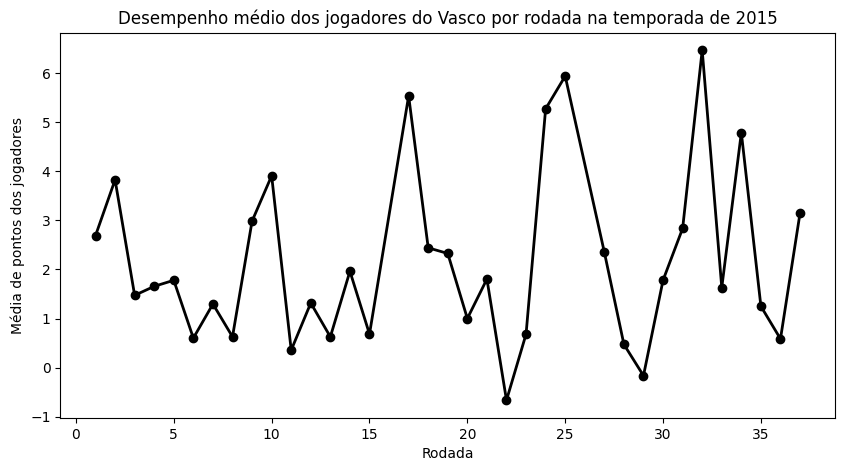

In [15]:
time = "Vasco"
ano = 2015

ano_df = df_atuou[df_atuou["temporada"] == ano]
time_df = ano_df[ano_df["clube_nome"].str.lower() == time.lower()]

media_por_rodada = (
    time_df.groupby("partida_rodada")["scout_pontos_num"]
    .mean()
    .reset_index()
    .sort_values("partida_rodada")
)

plt.figure(figsize=(10, 5))
plt.plot(
    media_por_rodada["partida_rodada"],
    media_por_rodada["scout_pontos_num"],
    marker="o",
    linewidth=2,
    color="black"
)
plt.title(f"Desempenho médio dos jogadores do {time} por rodada na temporada de {ano}")
plt.xlabel("Rodada")
plt.ylabel("Média de pontos dos jogadores")
plt.show()



### Gráfico de Linha: Evolução do Preço do Gabriel Jesus em 2016

O gráfico a seguir mostra a **variação do preço de Gabriel Jesus** ao longo das rodadas do Campeonato Brasileiro de 2016.  
Cada ponto representa o **valor médio do jogador em uma rodada**, refletindo seu desempenho e valorização dentro do fantasy game ao longo da temporada.  

Essa análise permite identificar **momentos de destaque, de constância e de queda no rendimento individual**.

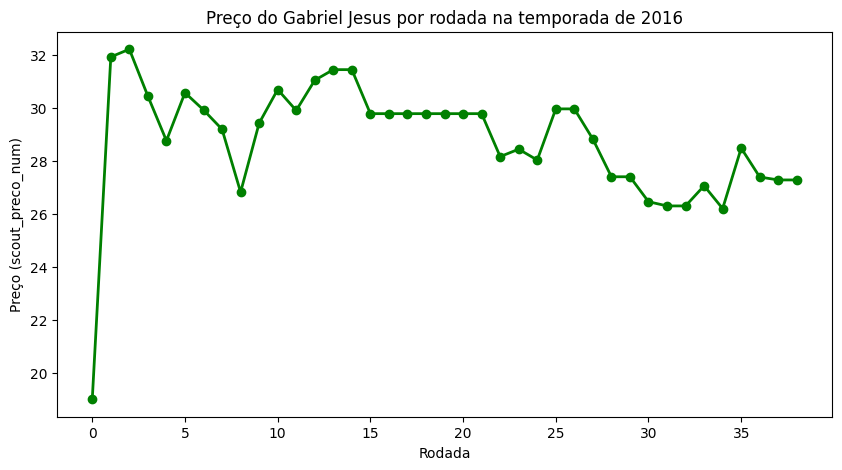

In [16]:
jogador = "Gabriel Jesus"
ano = 2016

ano_df = df[df["temporada"] == ano]
jogador_df = ano_df[ano_df["atleta_apelido"].str.lower() == jogador.lower()]

if jogador_df.empty:
    print(f"O jogador '{jogador}' não foi encontrado no Dataframe.")
else:
    preco_por_rodada = (
        jogador_df.groupby("partida_rodada")["scout_preco_num"]
        .mean()
        .reset_index()
        .sort_values("partida_rodada")
    )

    plt.figure(figsize=(10, 5))
    plt.plot(
        preco_por_rodada["partida_rodada"],
        preco_por_rodada["scout_preco_num"],
        marker="o",
        linewidth=2,
        color="green"
    )
    plt.title(f"Preço do {jogador} por rodada na temporada de {ano}")
    plt.xlabel("Rodada")
    plt.ylabel("Preço (scout_preco_num)")
    plt.show()

### Média da Pontuação do Gabriel Jesus pela Temporada de 2016

O gráfico abaixo mostra a **média de pontuação de Gabriel Jesus** em cada rodada do Campeonato Brasileiro de 2016.  
Cada ponto representa o **desempenho médio do jogador naquela rodada**, considerando todos os scouts registrados durante as partidas.  

Essa análise permite visualizar **momentos de destaque e oscilações no rendimento**, podendo fazer uma comparação com a tabela anterior, relacionando desempenho por preço.

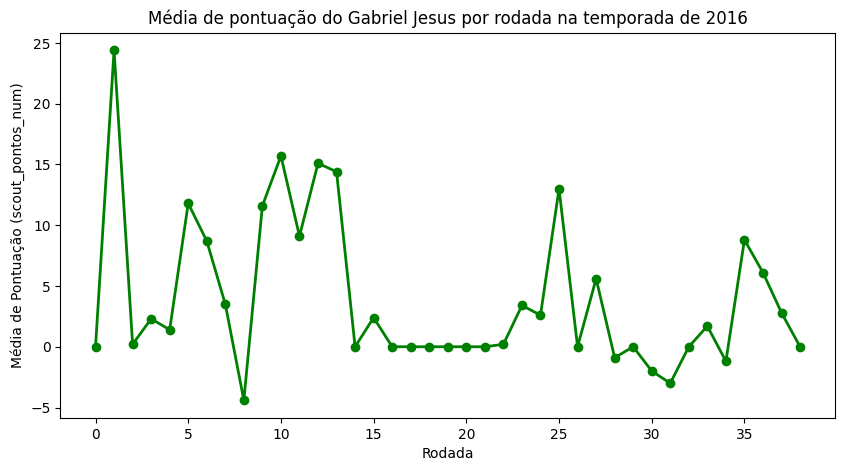

In [17]:
jogador = "Gabriel Jesus"
ano = 2016

ano_df = df[df["temporada"] == ano]
jogador_df = ano_df[ano_df["atleta_apelido"].str.lower() == jogador.lower()]

if jogador_df.empty:
    print(f"O jogador '{jogador}' não foi encontrado no Dataframe.")
else:
    preco_por_rodada = (
        jogador_df.groupby("partida_rodada")["scout_pontos_num"]
        .mean()
        .reset_index()
        .sort_values("partida_rodada")
    )

    plt.figure(figsize=(10, 5))
    plt.plot(
        preco_por_rodada["partida_rodada"],
        preco_por_rodada["scout_pontos_num"],
        marker="o",
        linewidth=2,
        color="green"
    )
    plt.title(f"Média de pontuação do {jogador} por rodada na temporada de {ano}")
    plt.xlabel("Rodada")
    plt.ylabel("Média de Pontuação (scout_pontos_num)")
    plt.show()

### Comparativo de Preço pelas temporadas de 2014 à 2017

O gráfico abaixo apresenta a **variação do preço de Fernando Prass** em cada rodada das temporadas de 2014 a 2017. O jogador escolhido por ter participado de todas as edições disponíveis do dataset.  
Cada linha representa uma temporada, permitindo acompanhar como o **desempenho e valorização do jogador** evoluíram ao longo dos anos.  

Essa análise possibilita identificar **picos de valorização, momentos de estabilidade e possíveis quedas de rendimento**, oferecendo uma visão clara da trajetória do jogador ao longo das diferentes edições do Campeonato Brasileiro. 

O jogador 'Fernando Prass' não foi encontrado na temporada 2017.


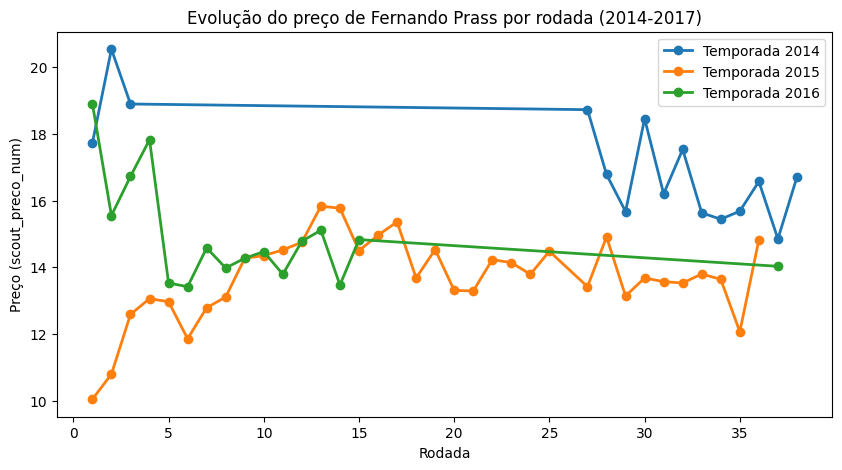

### Preço Mínimo e Máximo de Fernando Prass por Temporada (2014-2017)

,Temporada,Preço Mínimo,Preço Máximo
0,2014,14.85,20.53
1,2015,10.05,15.83
2,2016,13.42,18.90


In [18]:
import matplotlib.pyplot as plt

jogador = "Fernando Prass"
time = "Palmeiras"
anos = [2014, 2015, 2016, 2017]

plt.figure(figsize=(10, 5))

for ano in anos:
    ano_df = df_atuou[df_atuou["temporada"] == ano]
    time_df = ano_df[ano_df["clube_nome"].str.lower() == time.lower()]
    jogador_df = time_df[time_df["atleta_apelido"].str.lower() == jogador.lower()]

    if jogador_df.empty:
        print(f"O jogador '{jogador}' não foi encontrado na temporada {ano}.")
        continue

    preco_por_rodada = (
        jogador_df.groupby("partida_rodada")["scout_preco_num"]
        .mean()
        .reset_index()
        .sort_values("partida_rodada")
    )

    plt.plot(
        preco_por_rodada["partida_rodada"],
        preco_por_rodada["scout_preco_num"],
        marker="o",
        linewidth=2,
        label=f"Temporada {ano}"
    )

plt.title(f"Evolução do preço de {jogador} por rodada (2014-2017)")
plt.xlabel("Rodada")
plt.ylabel("Preço (scout_preco_num)")
plt.legend()
plt.show()

tabela_precos = []

for ano in anos:
    ano_df = df_atuou[df_atuou["temporada"] == ano]
    time_df = ano_df[ano_df["clube_nome"].str.lower() == time.lower()]
    jogador_df = time_df[time_df["atleta_apelido"].str.lower() == jogador.lower()]

    if jogador_df.empty:
        continue

    preco_min = jogador_df["scout_preco_num"].min()
    preco_max = jogador_df["scout_preco_num"].max()
    
    tabela_precos.append({
        "Temporada": ano,
        "Preço Mínimo": preco_min,
        "Preço Máximo": preco_max
    })

tabela_precos_df = pd.DataFrame(tabela_precos)
display(Markdown("### Preço Mínimo e Máximo de Fernando Prass por Temporada (2014-2017)"))
display(tabela_precos_df)

### Gráfico de Pizza: Proporção dos jogador por posição de 2014 à 2017

A seguir, apresentamos a **proporção de jogadores em cada posição** ao longo das temporadas de 2014 a 2017.  
Cada gráfico de pizza mostra como os jogadores estão distribuídos entre **Goleiro, Zagueiro, Lateral, Meio, Atacante e Técnico** para o respectivo ano.

Essas visualizações permitem observar mudanças na composição das equipes ao longo dos anos e identificar quais posições têm mais ou menos jogadores registrados em cada temporada.

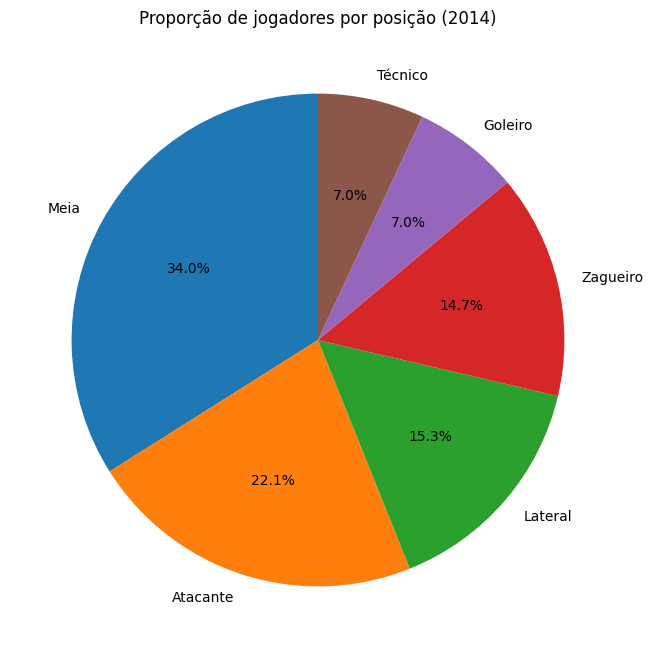

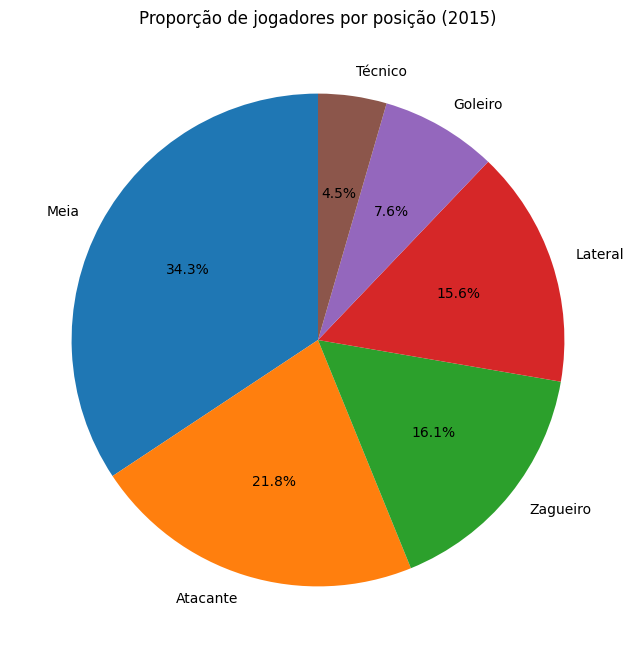

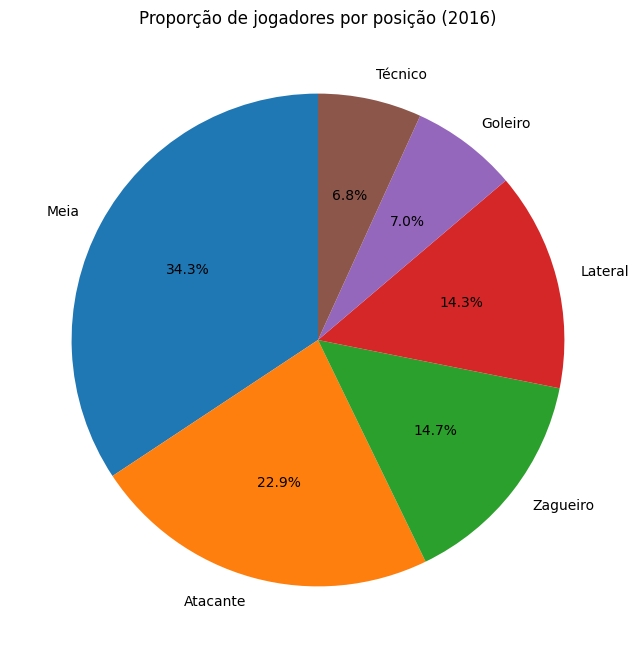

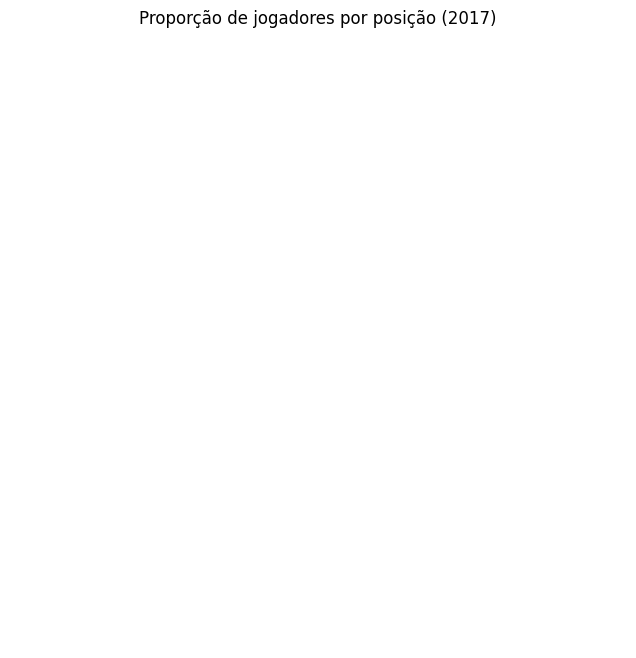

In [19]:
posicoes_count = df_2014["atleta_posicao"].value_counts()
plt.figure(figsize=(8,8))
plt.pie(posicoes_count, labels=posicoes_count.index, autopct='%1.1f%%', startangle=90)
plt.title("Proporção de jogadores por posição (2014)")
plt.show()

posicoes_count = df_2015["atleta_posicao"].value_counts()
plt.figure(figsize=(8,8))
plt.pie(posicoes_count, labels=posicoes_count.index, autopct='%1.1f%%', startangle=90)
plt.title("Proporção de jogadores por posição (2015)")
plt.show()

posicoes_count = df_2016["atleta_posicao"].value_counts()
plt.figure(figsize=(8,8))
plt.pie(posicoes_count, labels=posicoes_count.index, autopct='%1.1f%%', startangle=90)
plt.title("Proporção de jogadores por posição (2016)")
plt.show()

posicoes_count = df_2017["atleta_posicao"].value_counts()
plt.figure(figsize=(8,8))
plt.pie(posicoes_count, labels=posicoes_count.index, autopct='%1.1f%%', startangle=90)
plt.title("Proporção de jogadores por posição (2017)")
plt.show()




### Gráfico de Barras: Top 10 jogadores com mais pontos somados por ano de 2014 à 2017

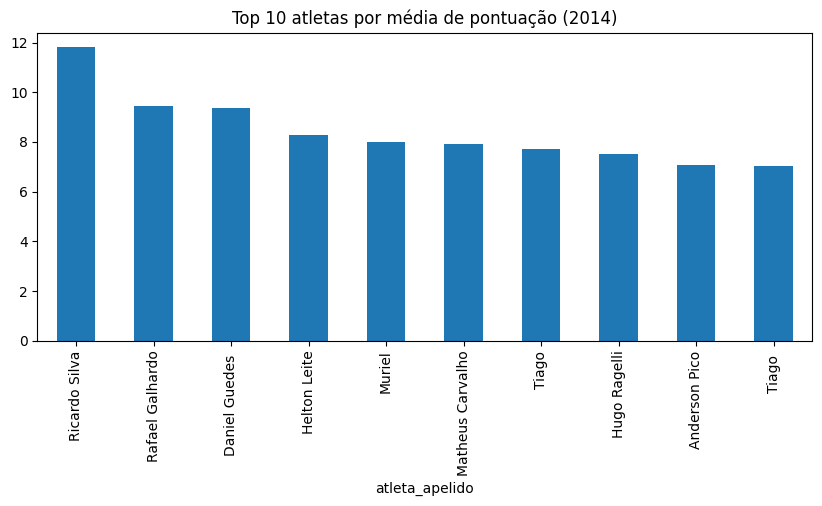

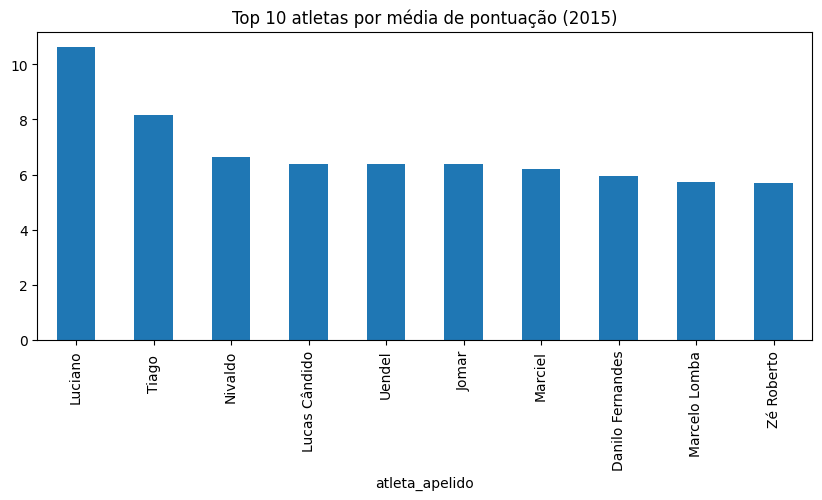

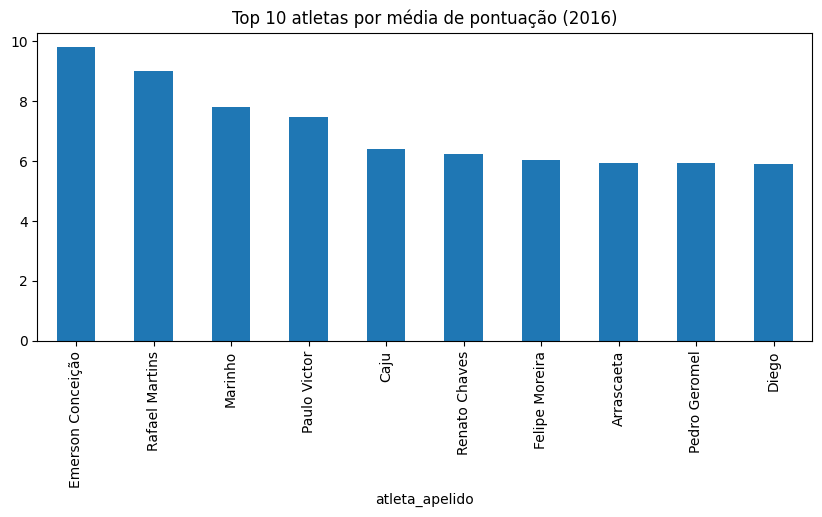

Não há dados disponíveis para a temporada de 2017.


In [20]:
top10 = (
    df_2014.groupby(["atleta_apelido"])["scout_pontos_num"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

top10.plot(kind="bar", figsize=(10,4), title="Top 10 atletas por média de pontuação (2014)")
plt.show()

top10 = (
    df_2015.groupby(["atleta_apelido"])["scout_pontos_num"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

top10.plot(kind="bar", figsize=(10,4), title="Top 10 atletas por média de pontuação (2015)")
plt.show()

top10 = (
    df_2016.groupby(["atleta_apelido"])["scout_pontos_num"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

top10.plot(kind="bar", figsize=(10,4), title="Top 10 atletas por média de pontuação (2016)")
plt.show()

if df_2017.empty:
    print("Não há dados disponíveis para a temporada de 2017.")
else:
    top10 = (
        df_2017.groupby(["atleta_apelido"])["scout_pontos_num"]
        .mean()
        .sort_values(ascending=False)
        .head(10)
    )

    top10.plot(kind="bar", figsize=(10,4), title="Top 10 atletas por média de pontuação (2017)")
    plt.show()



### Evolução do Preço Médio dos Atletas
O gráfico abaixo mostra a **variação do preço médio dos jogadores** ao longo das temporadas disponíveis no dataset.  
Cada ponto representa a média de preço em uma temporada, permitindo acompanhar tendências de valorização ou desvalorização dos atletas ao longo dos anos.

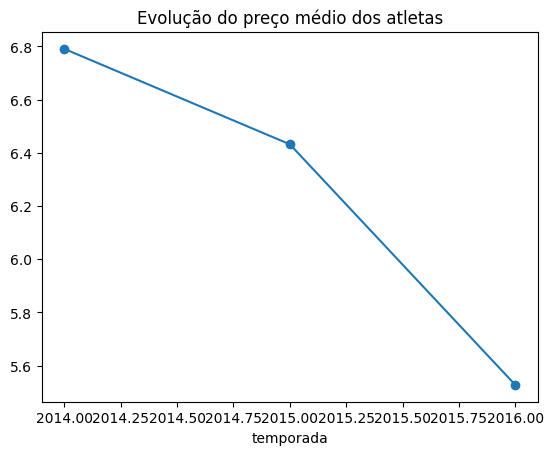

In [21]:
df.groupby("temporada")["scout_preco_num"].mean().plot(
    marker="o", title="Evolução do preço médio dos atletas"
)
plt.show()

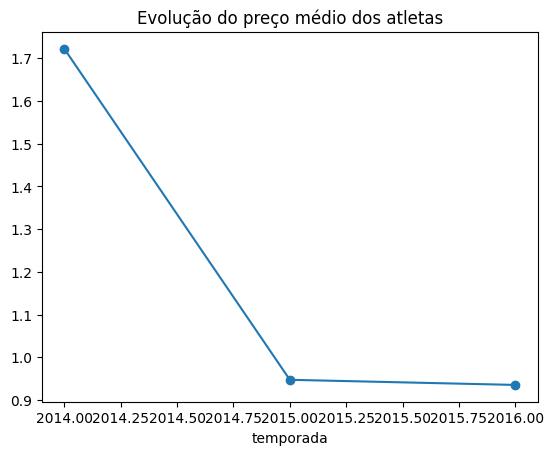

rodou


In [22]:
df.groupby("temporada")["scout_pontos_num"].mean().plot(
    marker="o", title="Evolução do preço médio dos atletas"
)
plt.show()
print('rodou')

# Matriz de Confusão 
Para compreendermos melhor a respeito o impacto de cada coluna de scout em cima da coluna principal (scout_pontos_num), iremos fazer uma matriz de confusão para cada posição.

## Matriz de Confusão - Goleiro


Posição: Goleiro | Amostras: 8012 | Features: 18
              precision    recall  f1-score   support

       Baixa      0.924     0.956     0.940      1947
        Alta      0.781     0.665     0.719       457

    accuracy                          0.901      2404
   macro avg      0.853     0.811     0.829      2404
weighted avg      0.897     0.901     0.898      2404



<Figure size 500x400 with 0 Axes>

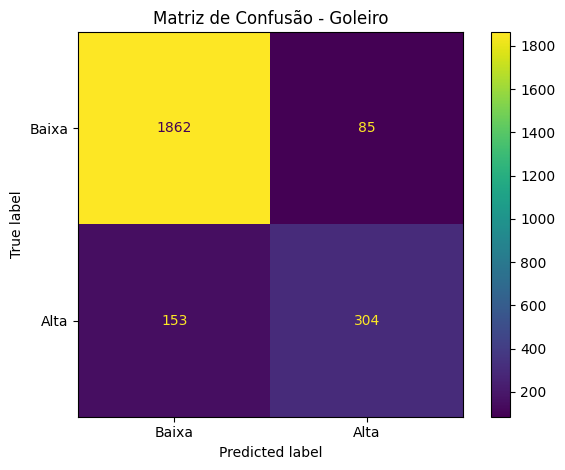


Posição: Lateral | Amostras: 11468 | Features: 18


              precision    recall  f1-score   support

       Baixa      0.798     0.898     0.845      2385
        Alta      0.679     0.486     0.566      1056

    accuracy                          0.772      3441
   macro avg      0.738     0.692     0.706      3441
weighted avg      0.761     0.772     0.759      3441



<Figure size 500x400 with 0 Axes>

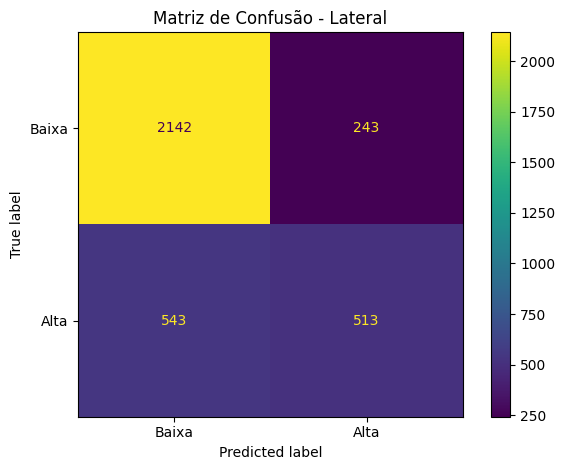


Posição: Zagueiro | Amostras: 12082 | Features: 18
              precision    recall  f1-score   support

       Baixa      0.821     0.882     0.851      2604
        Alta      0.630     0.509     0.563      1021

    accuracy                          0.777      3625
   macro avg      0.725     0.696     0.707      3625
weighted avg      0.767     0.777     0.770      3625



<Figure size 500x400 with 0 Axes>

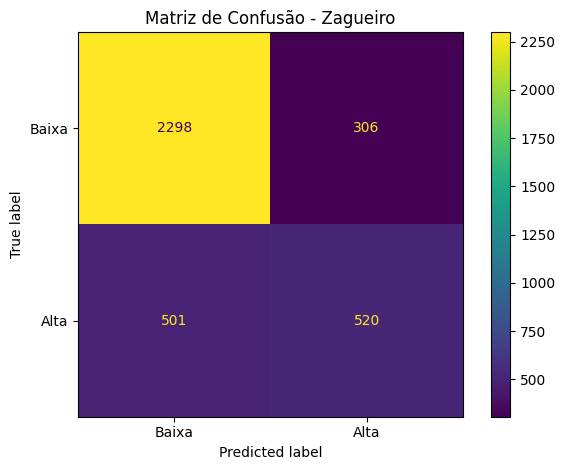


Posição: Meia | Amostras: 25469 | Features: 18
              precision    recall  f1-score   support

       Baixa      0.807     0.903     0.852      5409
        Alta      0.670     0.477     0.557      2232

    accuracy                          0.779      7641
   macro avg      0.738     0.690     0.705      7641
weighted avg      0.767     0.779     0.766      7641



<Figure size 500x400 with 0 Axes>

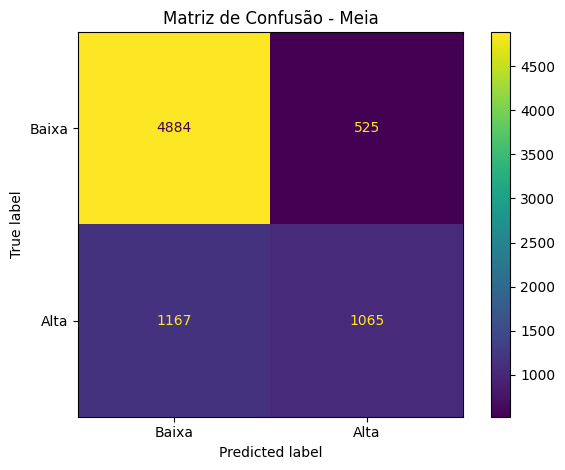


Posição: Atacante | Amostras: 15807 | Features: 18
              precision    recall  f1-score   support

       Baixa      0.795     0.900     0.844      3292
        Alta      0.677     0.473     0.557      1451

    accuracy                          0.770      4743
   macro avg      0.736     0.687     0.701      4743
weighted avg      0.759     0.770     0.757      4743



<Figure size 500x400 with 0 Axes>

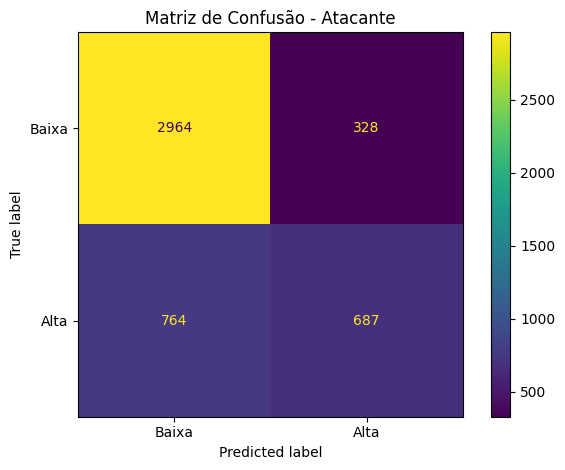


Posição: Técnico | Amostras: 1985 | Features: 18
              precision    recall  f1-score   support

       Baixa      0.082     1.000     0.152        49
        Alta      0.000     0.000     0.000       547

    accuracy                          0.082       596
   macro avg      0.041     0.500     0.076       596
weighted avg      0.007     0.082     0.012       596



/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<Figure size 500x400 with 0 Axes>

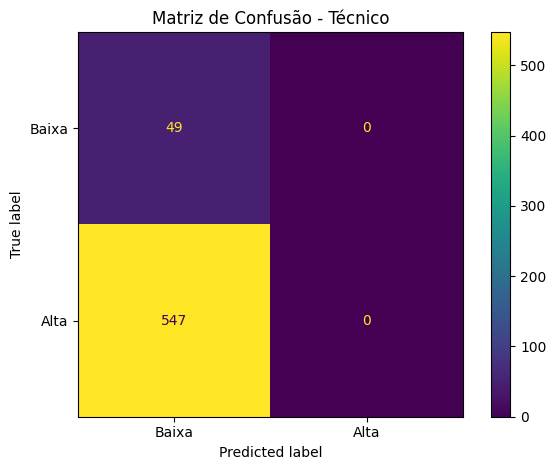

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

POSICOES = ["Goleiro", "Lateral", "Zagueiro", "Meia", "Atacante", "Técnico"]

# Colunas de scout disponíveis no dataset
scout_cols = ["FS", "PE", "A", "FT", "FD", "FF", "G", "I", "PP", "RB", "FC", "GC", "CA", "CV", "SG", "DD", "DP", "GS"]
# Verificar quais existem no dataframe
scout_cols = [c for c in scout_cols if c in df.columns]

target_col = "scout_pontos_num"
pos_col = "atleta_posicao" 

missing = [c for c in [target_col, pos_col] + scout_cols if c not in df.columns]
if missing:
    raise ValueError(f"Colunas faltantes no df: {missing}")


strategy = "mediana" 

df = df.copy()
df["_alvo_classe"] = np.nan

if strategy == "mediana":
    lim = df[target_col].median()
    df["_alvo_classe"] = (df[target_col] > lim).astype(int)  
    class_labels = ["Baixa", "Alta"]
elif strategy == "tercis":
    tercis = pd.qcut(df[target_col], q=3, labels=False, duplicates="drop")
    df["_alvo_classe"] = tercis
    class_labels = ["Baixa", "Média", "Alta"]
else:
    raise ValueError("strategy deve ser 'mediana' ou 'tercis'")

df_clean = df.dropna(subset=scout_cols + ["_alvo_classe", pos_col])

def matriz_confusao_por_posicao(
    df_pos: pd.DataFrame,
    X_cols: list,
    y_col: str,
    class_labels: list,
    test_size: float = 0.3,
    random_state: int = 42
):
    if df_pos.shape[0] < 20:
        print(f"[Aviso] Amostra pequena ({df_pos.shape[0]}) — resultados podem ser instáveis.")
    # X e y
    X = df_pos[X_cols].fillna(0.0)
    y = df_pos[y_col].astype(int)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )


    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", LogisticRegression(max_iter=500, class_weight="balanced", n_jobs=None))
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Métricas
    print(classification_report(y_test, y_pred, target_names=class_labels, digits=3))

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred, labels=sorted(np.unique(y)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    plt.figure(figsize=(5, 4))
    disp.plot(values_format="d")
    plt.title(f"Matriz de Confusão - {df_pos.iloc[0][pos_col]}")
    plt.tight_layout()
    plt.show()

for pos in POSICOES:
    df_pos = df_clean[df_clean[pos_col] == pos]
    if df_pos.empty:
        print(f"Sem dados para posição: {pos}")
        continue
    print("\n" + "="*70)
    print(f"Posição: {pos} | Amostras: {len(df_pos)} | Features: {len(scout_cols)}")
    matriz_confusao_por_posicao(df_pos, scout_cols, "_alvo_classe", class_labels)

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Colunas de scout disponíveis no dataset
scout_cols = ["FS", "PE", "A", "FT", "FD", "FF", "G", "I", "PP", "RB", "FC", "GC", "CA", "CV", "SG", "DD", "DP", "GS"]
# Verificar quais existem no dataframe
scout_cols = [c for c in scout_cols if c in df.columns]

target_col = "scout_pontos_num"
pos_col = "atleta_posicao"


def impacto_por_posicao(df, pos):
    df_pos = df[df[pos_col] == pos].dropna(subset=scout_cols + [target_col])
    if df_pos.empty or df_pos.shape[0] < 30:
        print(f"[Aviso] Poucos dados para posição: {pos}")
        return None

    X = df_pos[scout_cols].fillna(0.0)
    y = df_pos[target_col]

    scaler = StandardScaler(with_mean=True, with_std=True)
    X_scaled = scaler.fit_transform(X)

    reg = LinearRegression()
    reg.fit(X_scaled, y)

    # Coeficientes padronizados
    coefs = reg.coef_
    
    impacto_df = pd.DataFrame({
        "variavel": scout_cols,
        "impacto": coefs
    }).sort_values("impacto", key=abs, ascending=False)
    
    return impacto_df

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Colunas de scout disponíveis no dataset
scout_cols = ["FS", "PE", "A", "FT", "FD", "FF", "G", "I", "PP", "RB", "FC", "GC", "CA", "CV", "SG", "DD", "DP", "GS"]
# Verificar quais existem no dataframe
scout_cols = [c for c in scout_cols if c in df.columns]

target_col = "scout_pontos_num"
pos_col = "atleta_posicao"

def impacto_por_posicao(df, pos):
    df_pos = df[df[pos_col] == pos].dropna(subset=scout_cols + [target_col])
    if df_pos.empty or df_pos.shape[0] < 30:
        print(f"[Aviso] Poucos dados para posição: {pos}")
        return None

    X = df_pos[scout_cols].fillna(0)
    y = df_pos[target_col]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = LinearRegression()
    model.fit(X_scaled, y)

    impacto = pd.DataFrame({
        "variavel": scout_cols,
        "impacto": model.coef_
    }).sort_values("impacto", ascending=False)

    return impacto

POSICOES = ["Goleiro", "Zagueiro", "Lateral", "Meia", "Atacante", "Técnico"]

## Impactos para gerar a pontuação do goleiro

/tmp/ipykernel_7/155684832.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


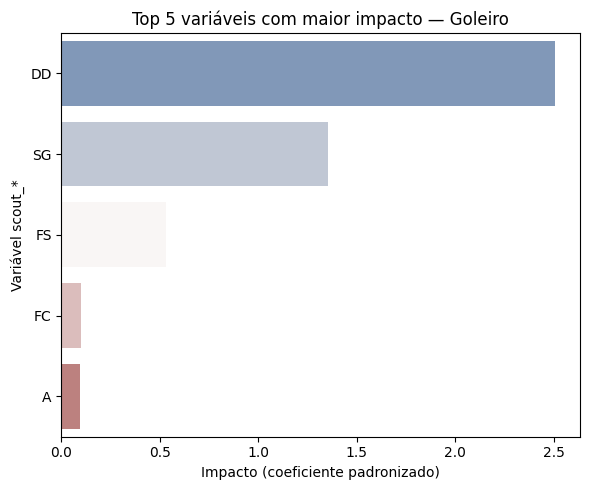

In [26]:
impacto_gol = impacto_por_posicao(df, "Goleiro")

plt.figure(figsize=(6,5))
sns.barplot(
    data=impacto_gol.head(5),
    x="impacto",
    y="variavel",
    palette="vlag"
)
plt.title("Top 5 variáveis com maior impacto — Goleiro")
plt.xlabel("Impacto (coeficiente padronizado)")
plt.ylabel("Variável scout_*")
plt.tight_layout()
plt.show()

**Análise - Goleiro**

Os goleiros têm como principais variáveis de impacto positivo:
- `scout_ponto_por_defesa_dificil` → É o maior fator de influência, mostrando que as defesas difíceis são o componente mais relevante para pontuação alta.
- `scout_ponto_por_nao_sofrer_gol` → Vem logo em seguida, reforçando a importância de manter o time sem gols sofridos.
- `scout_ponto_por_falta_sofrida` tem um peso leve, indicando contribuições ocasionais.

As variáveis negativas — `falta_cometida` e `assistencia` — praticamente não interferem (esta última aparece por correlação, não por contribuição real).

**Interpretação geral:** o desempenho defensivo e o número de defesas são os fatores mais determinantes para a pontuação dos goleiros.

## Impactos para gerar a pontuação do zagueiro

/tmp/ipykernel_7/854353331.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


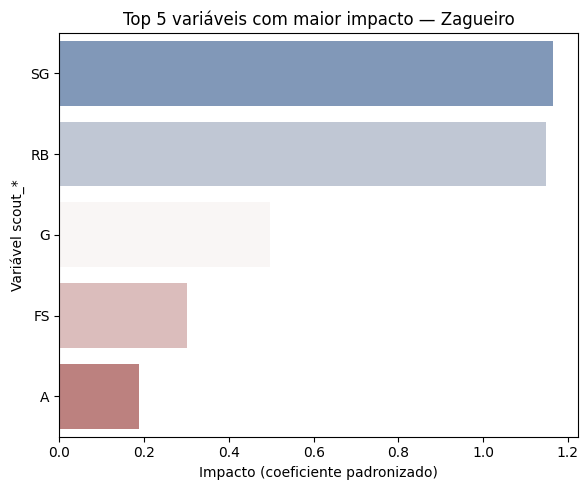

In [27]:
impacto_zag = impacto_por_posicao(df, "Zagueiro")

plt.figure(figsize=(6,5))
sns.barplot(
    data=impacto_zag.head(5),
    x="impacto",
    y="variavel",
    palette="vlag"
)
plt.title("Top 5 variáveis com maior impacto — Zagueiro")
plt.xlabel("Impacto (coeficiente padronizado)")
plt.ylabel("Variável scout_*")
plt.tight_layout()
plt.show()


**Análise - Zagueiro**

Os zagueiros apresentam impacto positivo maior em:
- `scout_ponto_por_nao_sofrer_gol` e `scout_ponto_por_roubada_de_bola` → principais fontes de pontuação, reforçando o peso da solidez defensiva.
- `scout_ponto_por_gol` também tem relevância, mas menor, já que gols são mais raros para defensores.

Os fatores negativos (`falta_sofrida` e `assistencia`) aparecem com peso baixo, representando ruído estatístico.

**Interpretação geral:** o zagueiro pontua bem quando a equipe mantém o “clean sheet” e quando ele se destaca defensivamente com roubadas de bola.


## Impactos para gerar a pontuação do lateral

/tmp/ipykernel_7/4041451641.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


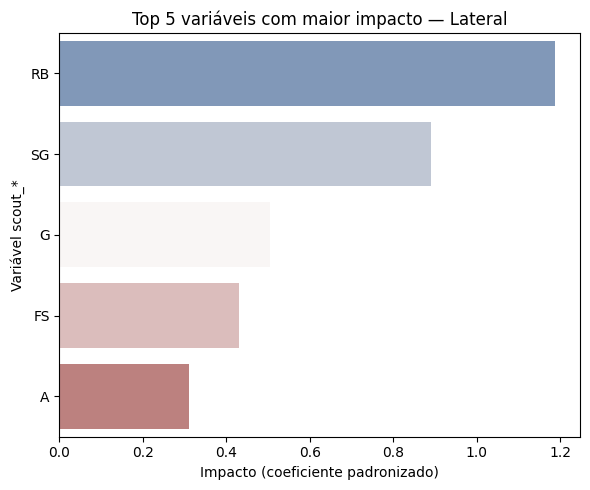

In [28]:
impacto_lat = impacto_por_posicao(df, "Lateral")

plt.figure(figsize=(6,5))
sns.barplot(
    data=impacto_lat.head(5),
    x="impacto",
    y="variavel",
    palette="vlag"
)
plt.title("Top 5 variáveis com maior impacto — Lateral")
plt.xlabel("Impacto (coeficiente padronizado)")
plt.ylabel("Variável scout_*")
plt.tight_layout()
plt.show()


**Análise - Lateral**

Entre os laterais, o comportamento é híbrido:
- `scout_ponto_por_roubada_de_bola` e `scout_ponto_por_nao_sofrer_gol` são os maiores contribuintes — reforçando o papel defensivo.
- `scout_ponto_por_gol` e `assistencia` também aparecem positivamente, indicando impacto ofensivo.

**Interpretação geral:** o lateral combina fatores de defesa e ataque. Ele pontua bem quando participa do jogo ofensivo **sem comprometer a defesa**, equilibrando os dois lados.


## Impactos para gerar a pontuação do meia

/tmp/ipykernel_7/3225379824.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


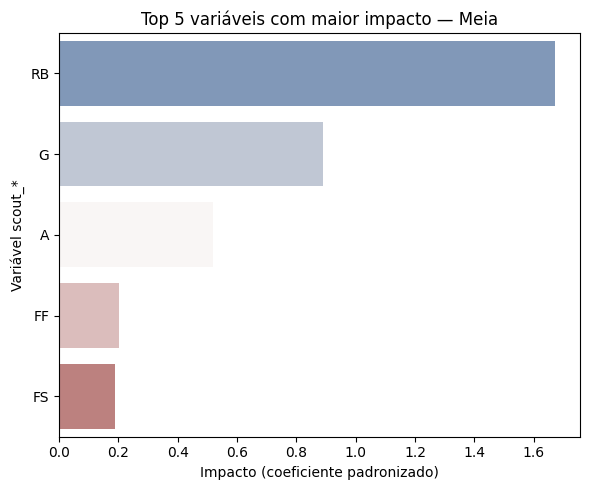

In [29]:
impacto_meia = impacto_por_posicao(df, "Meia")

plt.figure(figsize=(6,5))
sns.barplot(
    data=impacto_meia.head(5),
    x="impacto",
    y="variavel",
    palette="vlag"
)
plt.title("Top 5 variáveis com maior impacto — Meia")
plt.xlabel("Impacto (coeficiente padronizado)")
plt.ylabel("Variável scout_*")
plt.tight_layout()
plt.show()


**Análise - Meia**

Nos meias, as variáveis com maior impacto são:
- `scout_ponto_por_roubada_de_bola` e `scout_ponto_por_gol`, seguidas de `assistencia`.
- Isso reflete o papel duplo do meia: colaborar na marcação e criar chances de gol.

As variáveis negativas (`finalizacao_para_fora` e `falta_sofrida`) têm pouca influência.

**Interpretação geral:** meias pontuam melhor quando são **participativos ofensivamente** (gols/assistências) e **eficientes na recomposição** (roubadas de bola).


## Impactos para gerar a pontuação do atacante

/tmp/ipykernel_7/2175149327.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


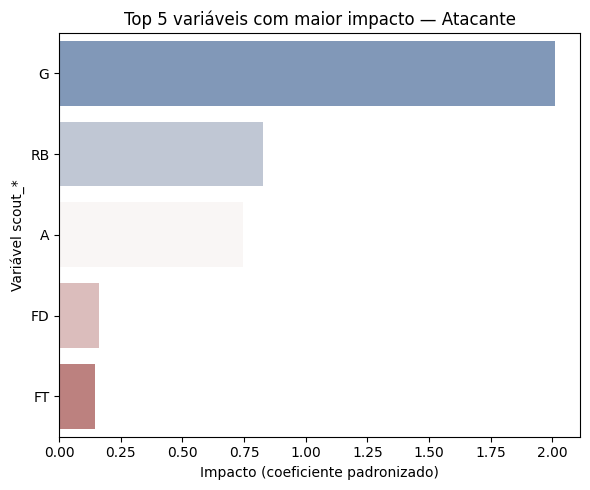

In [30]:
impacto_ata = impacto_por_posicao(df, "Atacante")

plt.figure(figsize=(6,5))
sns.barplot(
    data=impacto_ata.head(5),
    x="impacto",
    y="variavel",
    palette="vlag"
)
plt.title("Top 5 variáveis com maior impacto — Atacante")
plt.xlabel("Impacto (coeficiente padronizado)")
plt.ylabel("Variável scout_*")
plt.tight_layout()
plt.show()


**Análise - Atacante**

O atacante tem o perfil mais direto:
- `scout_ponto_por_gol` é, de longe, a variável mais determinante.
- `scout_ponto_por_roubada_de_bola` e `assistencia` vêm em seguida, com pesos menores mas ainda relevantes.
- Finalizações na trave ou defendidas aparecem de forma residual.

**Interpretação geral:** a pontuação dos atacantes depende **quase totalmente da efetividade ofensiva** — marcar gols e participar de jogadas decisivas.


## Impactos para gerar a pontuação do técnico

/tmp/ipykernel_7/3153563037.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


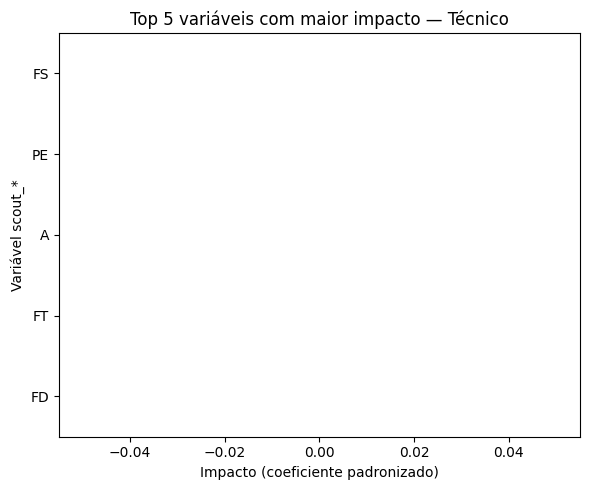

In [31]:
impacto_tec = impacto_por_posicao(df, "Técnico")

plt.figure(figsize=(6,5))
sns.barplot(
    data=impacto_tec.head(5),
    x="impacto",
    y="variavel",
    palette="vlag"
)
plt.title("Top 5 variáveis com maior impacto — Técnico")
plt.xlabel("Impacto (coeficiente padronizado)")
plt.ylabel("Variável scout_*")
plt.tight_layout()
plt.show()


**Análise - Técnico**

Os coeficientes do técnico aparecem praticamente zerados.  
Isso ocorre porque, segundo a **regra de negócio do Cartola**, a pontuação do técnico é **calculada como a média das pontuações dos jogadores do time**.

**Interpretação geral:** o técnico **não tem impacto direto** das variáveis de scout — sua pontuação é derivada da performance coletiva.
